# Appendix A: 
## Data Loading and Exploration 

ADS 599 Capstone: NLP + Machine Learning Techniques to Identifying Fake Job Postings

Team 2:
* Brianne Bell 
* Zachariah Freitas

In [35]:
# loading the necessary libraries
import pandas as pd
import numpy as np
import os
import re
import random
import time
import datetime

import nltk
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from tqdm import tqdm
from wordcloud import WordCloud 
import textacy.preprocessing as tprep
from lexical_diversity import lex_div as ld

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.gridspec as gridspec # to do the grid of plots

%matplotlib inline

Loading up the original data from Kaggle.

In [20]:
file_path = 'C:/Users/breel.B-E-BELL/OneDrive/Documents/GitHub/ADS-599-Capstone/Data Folder/fake_job_postings.csv'
raw_df = pd.read_csv(file_path)
print('Raw Data Shape: ')
print(raw_df.shape)
print('\n', 'Columns in the raw data:')
print(raw_df.columns)

Raw Data Shape: 
(17880, 18)

 Columns in the raw data:
Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


In [21]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [24]:
# example of data contents
raw_df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


There are 18 columns, one of which is the outcome called fraudulent.
There are 17,880 entries, but there are null entries throughout. 

In [30]:
# looking at what is null
raw_df.isnull().sum().sort_values(ascending=False)

salary_range           15012
department             11547
required_education      8105
benefits                7210
required_experience     7050
function                6455
industry                4903
employment_type         3471
company_profile         3308
requirements            2695
location                 346
description                1
job_id                     0
telecommuting              0
has_questions              0
has_company_logo           0
title                      0
fraudulent                 0
dtype: int64

Overall, job_id, title, telecommuting, has_company_logo, has_questions, and fraudulent are the only columns with missing data. The description field is only missing one entry. The largest amount of missing entries is in salary_range followed by department. 

Let's look at the distribution of the target column, fraudulent. In this column, real job posts are classed as '0' while fraudulent jobs are classed as '1'.

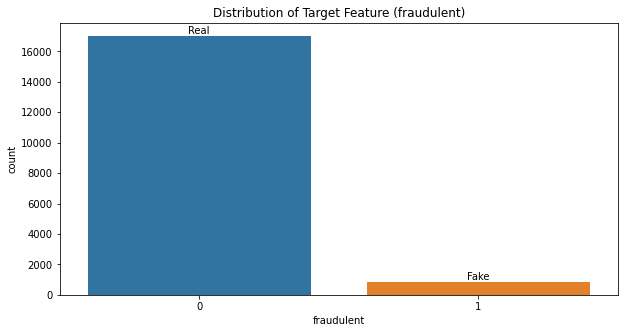

In [26]:
# plotting the target distribution
plt.figure(figsize=(10,5))
labels = ['Real', 'Fake']
bx = sns.countplot(x= 'fraudulent', data= raw_df)
plt.title('Distribution of Target Feature (fraudulent)')
bx.bar_label(bx.containers[0], label_type= 'edge', labels= labels)
plt.show()

In [28]:
raw_fake = raw_df[raw_df['fraudulent']==1]['fraudulent'].count()
raw_fake = round((raw_fake/len(raw_df))*100, 1)
print('There are ', raw_fake, 'percent fake job postings')

raw_real = raw_df[raw_df['fraudulent']==0]['fraudulent'].count()
raw_real = round((raw_real/len(raw_df))*100, 1)
print('There are ', raw_real, 'percent real job postings')

There are  4.8 percent fake job postings
There are  95.2 percent real job postings


Now that we know more about the raw data, we will begin manipulating the data to discover insights.

First to look at the categorical data.

In [32]:
# Dataframe of just the categorical features and target feature (binary)
## 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 
## 'required_education', 'industry', 'function', 'fraudulent'
cat_df = raw_df[['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 
                 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']]

# replace NaN with 'None'
cat_df = cat_df.fillna('None')

# checking
cat_df.head(5)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,None,None,Marketing,0
1,0,1,0,Full-time,Not Applicable,None,Marketing and Advertising,Customer Service,0
2,0,1,0,None,None,None,None,None,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


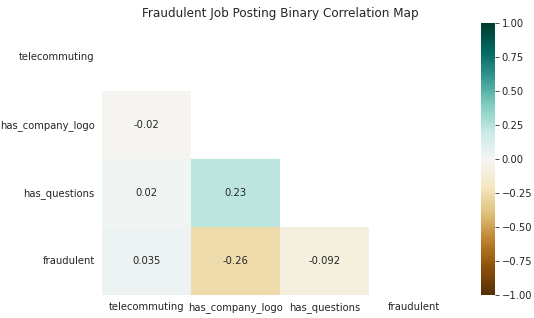

In [34]:
# looking at the binary categorical variables in a heatmap to determine correlation values:
mask = np.zeros_like(cat_df[['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']].corr())
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(8,5))
    ax = sns.heatmap(cat_df[['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']].corr(),
                     vmin=-1, vmax=1, annot=True, cmap='BrBG', mask=mask)
    ax.set_title('Fraudulent Job Posting Binary Correlation Map')

The heatmap shows low correlation between the binary variables as well as the variables with the target variable.
The main contendor for being correlated to fraudulent job post is the has_company_logo is strongest but only at -.26. 
Interestingly, has_questions and has_company_logo are correlated together but only at .23.

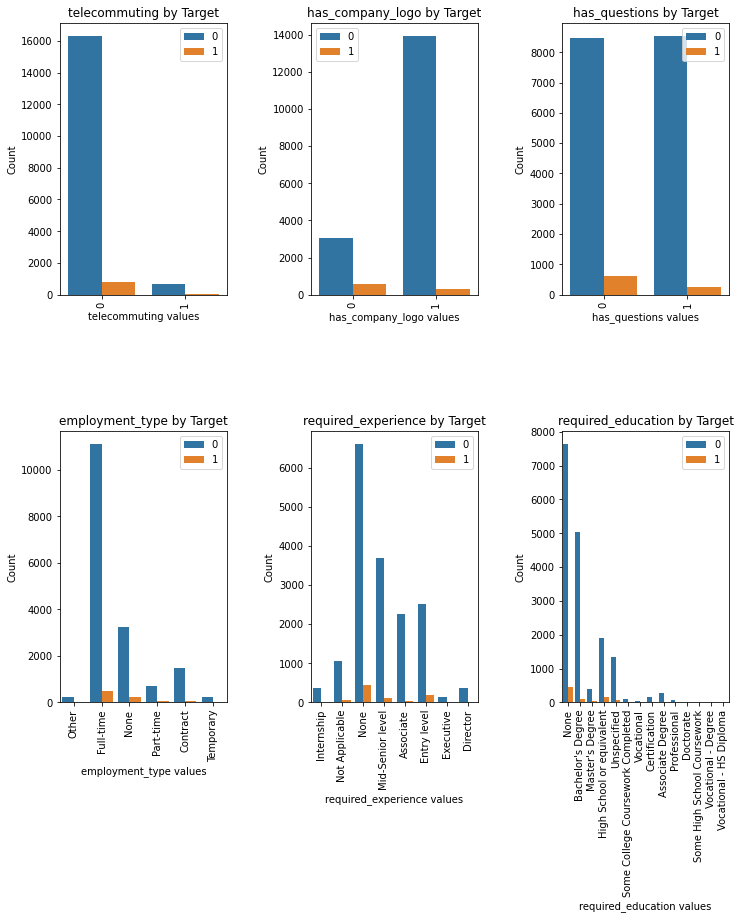

In [40]:
# looking at target as it relates to categorical data 
## removed industry and function as there were a lot of entries and the graphs were unreadable and uninteresting
cat_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 
                 'required_experience', 'required_education']

# setting up layout
grid = gridspec.GridSpec(3, 3, wspace= .5, hspace= .5)
plt.figure(figsize=(12,20))

# looping through columns
for n, col in enumerate(cat_df[cat_cols]):
    ax = plt.subplot(grid[n])
    sns.countplot(x= col, data= cat_df, hue= 'fraudulent')
    ax.set_ylabel('Count')
    ax.set_title(f'{col} by Target', fontsize=12)
    ax.set_xlabel(f'{col} values', fontsize=10)

    plt.xticks(rotation=90) #rotate labels 90degrees
    
    plt.legend()


plt.show()


Looking at the text based data

In [41]:
# Dataframe of just the text features and target feature (binary)
## title, company_profile, description, requirements, benefits, fraudulent
text_df = raw_df[['title', 'company_profile', 'description', 'requirements', 'benefits', 'fraudulent' ]]

# replace NaN values with ' '
text_df = text_df.fillna(' ')

# checking
text_df.head(5)

,title,company_profile,description,requirements,benefits,fraudulent
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0


In [43]:
# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison

# Stopwords
sw = stopwords.words("english")

In [42]:
# Helper Function - Descriptive Statistics
def descriptive_stats(tokens, top_n_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    if (len(tokens) == 0):
        raise ValueError("Can't work with empty text object.") 
    
    # These are placeholder values. 
    num_tokens = 1
    num_unique_tokens = 0
    avg_token_len = 0.0
    lexical_diversity = 0.0
    
    # Calculate statistics  
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = ld.ttr(tokens) # Simple TTR = len(Counter(text))/len(text)
    num_characters = sum([len(i) for i in tokens])
    avg_token_len = np.mean([len(w) for w in tokens]) 

    top_words = Counter(tokens).most_common(top_n_tokens)

    # Inline Printing     
    if verbose:        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The average token length in the data is {avg_token_len:.3f}.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"\n\nThe top {top_n_tokens} most common tokens")
        print(top_words)

      
    # Return Dictionary
    results = { 'tokens' : num_tokens, 
            'unique_tokens' : num_unique_tokens,
            'avg_token_length' : avg_token_len,
            'lexical_diversity': lexical_diversity,
            'num_characters': num_characters,
            'top_words': top_words} 

    return(results) 

In [44]:
# Helper Functions - Cleaning data

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

def remove_punctuation(text, punct_set=punctuation) : 
    """This function removes punctuation from a string."""
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    return text.lower().strip().split() 

def remove_stop(tokens) :
    """This function removes stopwords from a list of tokens."""
    return([t for t in tokens if t.lower() not in sw])
    
def prepare(text, pipeline) : 
    """ This fuction manages and executes other functions like a pipline. """
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

In [48]:
# Helper Function - Flatten a List of Lists
def flatten_lists(list_of_lists):
    """This function flattens a list of lists into a single list."""
    return [i for s in list_of_lists for i in s]

In [45]:
# Clean and Tokenize Data
df = text_df.copy()

# new column of all the text information combined together, may not be necessary but could address missing values
df['all_text'] = df['title'] + ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

# applying the pipeline
my_pipeline = [normalize, remove_punctuation, tokenize, remove_stop]

# we need to apply text cleaning to all of the following:
## 'title', 'company_profile', 'description', 'requirements', 'benefits', 'all_text'
df["title_tokens"] = df["title"].apply(prepare, pipeline=my_pipeline)
df["company_profile_tokens"] = df["company_profile"].apply(prepare, pipeline=my_pipeline)
df["description_tokens"] = df["description"].apply(prepare, pipeline=my_pipeline)
df["requirements_tokens"] = df["requirements"].apply(prepare, pipeline=my_pipeline)
df["benefits_tokens"] = df["benefits"].apply(prepare, pipeline=my_pipeline)
df["all_text_tokens"] = df["all_text"].apply(prepare, pipeline=my_pipeline)

# checking
df.head(5)

,title,company_profile,description,requirements,benefits,fraudulent,all_text,title_tokens,company_profile_tokens,description_tokens,requirements_tokens,benefits_tokens,all_text_tokens
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,"Marketing Intern We're Food52, and we've creat...","[marketing, intern]","[food52, weve, created, groundbreaking, awardw...","[food52, fastgrowing, james, beard, awardwinni...","[experience, content, management, systems, maj...",[],"[marketing, intern, food52, weve, created, gro..."
1,Customer Service - Cloud Video Production,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,Customer Service - Cloud Video Production 90 S...,"[customer, service, cloud, video, production]","[90, seconds, worlds, cloud, video, production...","[organised, focused, vibrant, awesomedo, passi...","[expect, youyour, key, responsibility, communi...","[get, usthrough, part, 90, seconds, team, gain...","[customer, service, cloud, video, production, ..."
2,Commissioning Machinery Assistant (CMA),Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,Commissioning Machinery Assistant (CMA) Valor ...,"[commissioning, machinery, assistant, cma]","[valor, services, provides, workforce, solutio...","[client, located, houston, actively, seeking, ...","[implement, precommissioning, commissioning, p...",[],"[commissioning, machinery, assistant, cma, val..."
3,Account Executive - Washington DC,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,Account Executive - Washington DC Our passion ...,"[account, executive, washington, dc]","[passion, improving, quality, life, geography,...","[company, esri, –, environmental, systems, res...","[education, bachelors, masters, gis, business,...","[culture, anything, corporate—we, collaborativ...","[account, executive, washington, dc, passion, ..."
4,Bill Review Manager,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,Bill Review Manager SpotSource Solutions LLC i...,"[bill, review, manager]","[spotsource, solutions, llc, global, human, ca...","[job, title, itemization, review, managerlocat...","[qualificationsrn, license, state, texasdiplom...","[full, benefits, offered]","[bill, review, manager, spotsource, solutions,..."


Running Descriptive Statistics and Creating WordClouds for the Description, Company Profile, and All Text Columns.

In [53]:
# Helper Function - Plot Word Cloud

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """
    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)



def plot_wc(wordcloud_df):
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    """
    plt.figure(figsize=(8,4))
    wordcloud(wordcloud_df['freq'], max_words=1000, stopwords=sw)


Focusing on Description text:
The five most common tokens are team, work, business, new, and experience.

In [57]:
# Statistics on Description
description_results = descriptive_stats(flatten_lists(df['description_tokens']))

There are 1921160 tokens in the data.
There are 103747 unique tokens in the data.
There are 14934566 characters in the data.
The average token length in the data is 7.774.
The lexical diversity is 0.054 in the data.


The top 5 most common tokens
[('team', 17284), ('work', 13991), ('business', 10419), ('new', 9692), ('experience', 9307)]


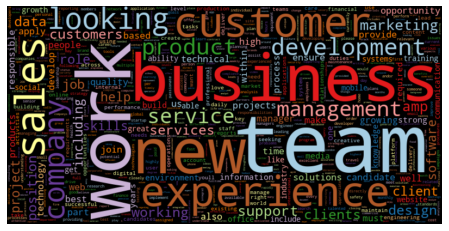

In [54]:
wordcloud_df = count_words(df, column='description_tokens')
plot_wc(wordcloud_df)

Focusing on Company Profile text:
The five most common tokens are team, work, services, company, and people.

In [58]:
# Statistics on Company Profile
company_profile_results = descriptive_stats(flatten_lists(df['company_profile_tokens']))

There are 1020807 tokens in the data.
There are 18786 unique tokens in the data.
There are 7403933 characters in the data.
The average token length in the data is 7.253.
The lexical diversity is 0.018 in the data.


The top 5 most common tokens
[('team', 7048), ('work', 6915), ('services', 6620), ('company', 6511), ('people', 6191)]


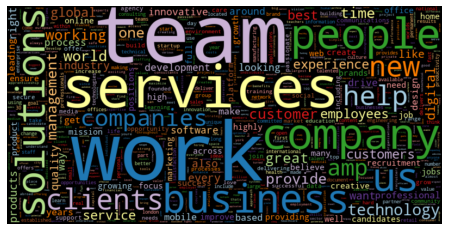

In [55]:
wordcloud_df = count_words(df, column='company_profile_tokens')
plot_wc(wordcloud_df)

Focusing on the created 'all text' information:
The five most common tokens are work, experience, team, business, and company.

In [59]:
# Statistics on the 'all text' column
all_text_results = descriptive_stats(flatten_lists(df['all_text_tokens']))

There are 4287775 tokens in the data.
There are 172071 unique tokens in the data.
There are 33007656 characters in the data.
The average token length in the data is 7.698.
The lexical diversity is 0.040 in the data.


The top 5 most common tokens
[('work', 34651), ('experience', 33081), ('team', 31383), ('business', 21172), ('company', 19601)]


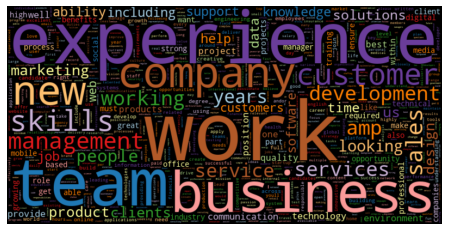

In [56]:
wordcloud_df = count_words(df, column='all_text_tokens')
plot_wc(wordcloud_df)

Looking at how target of fraudulent job posts compares to text data, particularly in the company profile, description, and all text columns.

In [60]:
# First, making columns for lengths of the tokenized company profile, description, and all text
df['description_token_length'] = df['description_tokens'].str.len()
df['company_profile_token_length'] = df['company_profile_tokens'].str.len()
df['all_text_token_length'] = df['all_text_tokens'].str.len()

[Text(0.5, 1.0, 'Description Length Against Target')]

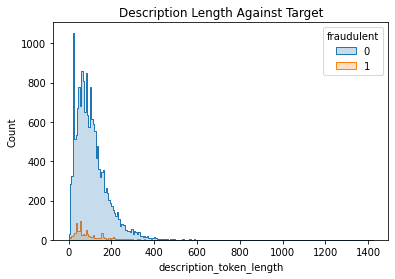

In [67]:
# plotting description length against fraudulent result
sns.histplot(data= df, x= 'description_token_length', 
             hue='fraudulent', element='step').set(title='Description Length Against Target')

It appears that fraudulent job posts tend to have shorter descriptions. By shorter, there are fewer than 200 tokens

[Text(0.5, 1.0, 'Company Profile Length Against Target')]

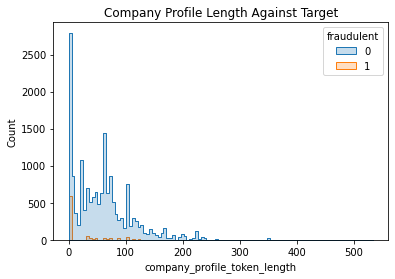

In [68]:
# plotting company_profile length against fraudulent result
sns.histplot(data= df, x= 'company_profile_token_length', 
             hue='fraudulent', element='step').set(title='Company Profile Length Against Target')

Fake job posts have very short or missing company profiles.

[Text(0.5, 1.0, 'All Text Length Against Target')]

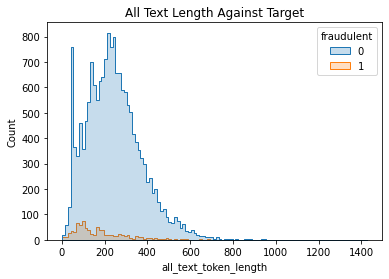

In [69]:
# plotting all_text length against fraudulent result
sns.histplot(data= df, x= 'all_text_token_length', 
             hue='fraudulent', element='step').set(title='All Text Length Against Target')

Looking at the text variables (title, company_profile, description, requirements, and benefits) all combined, the fake posts still keep things short at around 200 or fewer tokens. 
